Connected to orchidenv (Python 3.8.18)

In [27]:
# imports
import numpy as np
from keras import backend as K
K.set_image_data_format('channels_last')
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Flatten, Dropout, LayerNormalization, MultiHeadAttention, Layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns

In [28]:
# paths for training, validation, and testing sets
train_path = '/Users/alextowle/orchids/COM Research Seminar/orchid_data/HERO7 BLACK/train'
valid_path = '/Users/alextowle/orchids/COM Research Seminar/orchid_data/HERO7 BLACK/valid'
test_path = '/Users/alextowle/orchids/COM Research Seminar/orchid_data/HERO7 BLACK/test'

In [29]:
# method to crop an image
def crop(image):
    h, w, _ = image.shape
    min_dim = min(h, w)
    top = (h - min_dim) // 2
    left = (w - min_dim) // 2
    square_image = image[top:top + min_dim, left:left + min_dim]
    return square_image

In [30]:
# separate into batches of 3000x4000 size images
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size = (3000,4000), classes = ['control', 'overhydrated', 'underhydrated'], batch_size = 3, class_mode = 'categorical')
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size = (3000,4000), classes = ['control', 'overhydrated', 'underhydrated'], batch_size = 48, class_mode = 'categorical')
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (3000,4000), classes = ['control', 'overhydrated', 'underhydrated'], batch_size = 37, class_mode = 'categorical')

Found 1506 images belonging to 3 classes.
Found 432 images belonging to 3 classes.
Found 222 images belonging to 3 classes.


In [31]:
# test to show batch shape
x, y = next(train_batches)
print("Shape of the images batch:", x.shape)
print("Shape of the labels batch:", y.shape)

Shape of the images batch: (3, 3000, 4000, 3)
Shape of the labels batch: (3, 3)


In [32]:
# test method to display some sample images
def plots(ims, figsize = (12, 6), rows = 1, interp = False, titles = None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize = figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [33]:
# get the next batch
imgs, labels = next(train_batches)

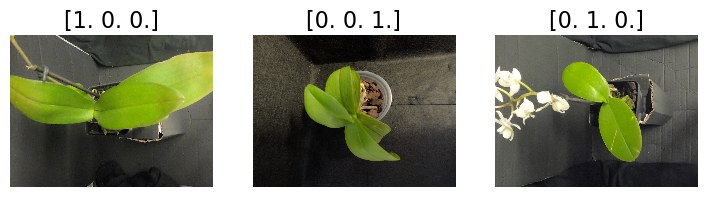

In [34]:
# show the batch plots
plots(imgs, titles = labels)

In [35]:
# method to augment images
# basically you it takes an image, a list of the factors you want to zoom it by,
# and a list of the angles you want it to turn by. It zooms that amount and then makes a version
# of the zoomed image for each angle.
# returns the augmented images
def augment_image(image, zoom_factors, angles):
    image = crop(image)
    image = image.astype(np.uint8)
    augmented_images = [image]
    height, width = image.shape[:2]

    for angle in angles:
        M = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
        rotated_img = cv2.warpAffine(image, M, (width, height))

        for zoom in zoom_factors:
            zoomed_img = cv2.resize(rotated_img, None, fx=zoom, fy=zoom, interpolation=cv2.INTER_LINEAR)
            
            start_x = (zoomed_img.shape[1] - width) // 2
            start_y = (zoomed_img.shape[0] - height) // 2
            cropped_img = zoomed_img[start_y:start_y + height, start_x:start_x + width]

            augmented_images.append(cropped_img)

    return augmented_images


In [36]:
# method to plot the augmented images
def plot_images(images, titles=None, rows=2):
    cols = len(images) // rows if len(images) % rows == 0 else len(images) // rows + 1
    plt.figure(figsize=(15, 10))

    for i in range(len(images)):
        plt.subplot(rows, cols, i+1)

        img = images[i]

        plt.imshow(img)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i], fontsize=10)
    plt.show()

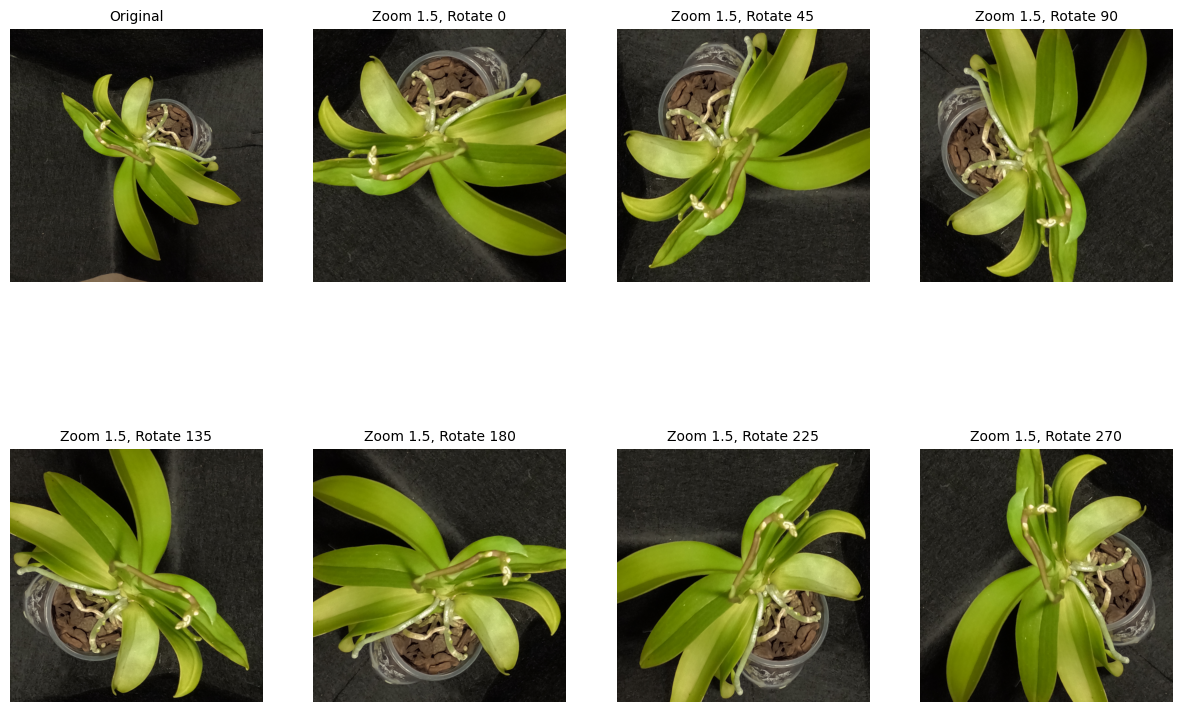

Original image min: 0.0, max: 255.0
Augmented image 0 min: 0, max: 255
Augmented image 1 min: 0, max: 255
Augmented image 2 min: 0, max: 255
Augmented image 3 min: 0, max: 255
Augmented image 4 min: 0, max: 255
Augmented image 5 min: 0, max: 255
Augmented image 6 min: 0, max: 255
Augmented image 7 min: 0, max: 255


In [37]:
#test to show augmentation
zoom_factors = [1.5]
angles = [45, 90, 135, 180, 225, 270, 315]

x_batch, y_batch = next(train_batches)

sample_image = x_batch[0]

augmented_images = augment_image(sample_image, zoom_factors, angles)

plot_images(augmented_images, titles=["Original"] + [f"Zoom {z}, Rotate {a}" for z in zoom_factors for a in [0] + angles])

print(f"Original image min: {sample_image.min()}, max: {sample_image.max()}")

for i, img in enumerate(augmented_images):
    print(f"Augmented image {i} min: {img.min()}, max: {img.max()}")


In [38]:
# actual class labels, angles, and zoom factors
class_labels = ['control', 'overhydrated', 'underhydrated']

zoom_factors = [1.5]
angles = [45, 90, 135, 180, 225, 270, 315]

In [39]:
# method to augment and save all image batches into a new folder
global_image_counter = 0

def augment_and_save_batches(batches, save_dir, steps):
    global global_image_counter
    
    for step in range(steps):
        batch = next(batches)
        images, labels = batch[0], batch[1]
        print(f"Processing batch {step + 1}/{steps}...")

        for i in range(len(images)):
            img = images[i]
            label_index = np.argmax(labels[i])
            label_name = class_labels[label_index]

            augmented_imgs = augment_image(img, zoom_factors, angles)

            for j, aug_img in enumerate(augmented_imgs):
                output_path = os.path.join(save_dir, label_name, f'{label_name}_aug_{global_image_counter}_{i}_{j}.jpg')
                
                global_image_counter += 1
                
                cv2.imwrite(output_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))


In [40]:
# paths where augmented images will be/are saved
train_mod_path = '/Users/alextowle/orchids/COM Research Seminar/orchid_data/HERO7 BLACK/train_mod'
valid_mod_path = '/Users/alextowle/orchids/COM Research Seminar/orchid_data/HERO7 BLACK/valid_mod'
test_mod_path = '/Users/alextowle/orchids/COM Research Seminar/orchid_data/HERO7 BLACK/test_mod'

In [53]:
# augment and save the batches
# ONLY DO THIS IF
# 1. YOU HAVE NEW IMAGES IN THE NON-MOD FOLDERS THAT NEED TO BE AUGMENTED (DELETE EXISTING DATA IN MOD FOLDERS FIRST)
# OR
# 2. THERE IS NOTHING IN THE MOD FOLDERS TO BEGIN WITH (YOU WILL NEED TO RUN THIS THE FIRST TIME SINCE I DIDN'T HAVE ENOUGH STORAGE TO SEND ALL THE MOD DATA)
# what i do is i clear out the mod folders when new images need to be added and augmented and then rerun this process
# not the most sophisticated approach i know but i had to work with what i did before i knew i needed augmentation
augment_and_save_batches(train_batches, train_mod_path, steps=502)
augment_and_save_batches(valid_batches, valid_mod_path, steps=9)
augment_and_save_batches(test_batches, test_mod_path, steps=6)

Processing batch 1/502...
Processing batch 2/502...
Processing batch 3/502...
Processing batch 4/502...
Processing batch 5/502...
Processing batch 6/502...
Processing batch 7/502...
Processing batch 8/502...
Processing batch 9/502...
Processing batch 10/502...
Processing batch 11/502...
Processing batch 12/502...
Processing batch 13/502...
Processing batch 14/502...
Processing batch 15/502...
Processing batch 16/502...
Processing batch 17/502...
Processing batch 18/502...
Processing batch 19/502...
Processing batch 20/502...
Processing batch 21/502...
Processing batch 22/502...
Processing batch 23/502...
Processing batch 24/502...
Processing batch 25/502...
Processing batch 26/502...
Processing batch 27/502...
Processing batch 28/502...
Processing batch 29/502...
Processing batch 30/502...
Processing batch 31/502...
Processing batch 32/502...
Processing batch 33/502...
Processing batch 34/502...
Processing batch 35/502...
Processing batch 36/502...
Processing batch 37/502...
Processing

In [42]:
# creating the mod batches
# i downsized these resolutions for training time purposes.
# playing with the resolution isn't something i had much time to experiment with but could be useful.
train_mod_batches = ImageDataGenerator(
    preprocessing_function=lambda x: x / 255.0
).flow_from_directory(
    train_mod_path,
    target_size=(224, 224),
    batch_size=6,
    class_mode='categorical'
)

valid_mod_batches = ImageDataGenerator(
    preprocessing_function=lambda x: x / 255.0
).flow_from_directory(
    valid_mod_path,
    target_size=(224, 224),
    batch_size=96,
    class_mode='categorical'
)
test_mod_batches = ImageDataGenerator(
    preprocessing_function=lambda x: x / 255.0
).flow_from_directory(
    test_mod_path, 
    target_size = (224,224), 
    batch_size = 74, 
    class_mode = 'categorical'
    )

Found 12048 images belonging to 3 classes.
Found 3456 images belonging to 3 classes.
Found 1776 images belonging to 3 classes.


In [43]:
# patch extraction layer
class PatchExtract(Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [44]:
# method to create the vit model
# still pretty basic, mostly cobbled together from what i learned through tutorials and had i little time to experiment with it
# worth playing around with some features
def create_vit_model(input_shape=(224, 224, 3), num_classes=3, patch_size=16, projection_dim=64, num_heads=4, transformer_layers=8):
    inputs = tf.keras.Input(shape=input_shape)
    
    # creates patches
    patches = PatchExtract(patch_size)(inputs)
    patch_embeddings = layers.Dense(units=projection_dim)(patches)

    # positional embeddings
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    positional_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    encoded_patches = patch_embeddings + positional_embedding

    # transformer layers
    for _ in range(transformer_layers):
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        
        x2 = layers.Add()([attention_output, encoded_patches])
        
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        
        mlp_output = Dense(units=projection_dim, activation='relu')(x3)
        mlp_output = Dropout(rate=0.1)(mlp_output)
        
        encoded_patches = layers.Add()([mlp_output, x2])

    # classification
    representation = Flatten()(encoded_patches)
    outputs = Dense(num_classes, activation='softmax')(representation)

    # create model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [45]:
# takes python generator and makes a tensorflow dataset object from it
# (cnn and vit can be picky about which one is used so i left both in because i was frequently changing approaches that needed one or the other)
def generator_to_tf_dataset(generator, batch_size):
    output_signature = (
        tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(batch_size, 3), dtype=tf.float32)
    )
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=output_signature
    )
    dataset = dataset.repeat()
    return dataset

In [46]:
# create the tensorflow datasets
train_tf_dataset = generator_to_tf_dataset(train_mod_batches, batch_size=6)
valid_tf_dataset = generator_to_tf_dataset(valid_mod_batches, batch_size=96)
test_tf_dataset = generator_to_tf_dataset(test_mod_batches, batch_size=74)

In [47]:
# creates the vit model. also provides the summary for debugging purposes
vit_model = create_vit_model(input_shape=(224, 224, 3), num_classes=3)
vit_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_extract_1     │ (None, None, 768) │          0 │ input_layer_1[0]… │
│ (PatchExtract)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, None, 64)  │     49,216 │ patch_extract_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 196, 64)   │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 196, 64)   │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 196, 64)   │          0 │ dense_11[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 196, 64)   │          0 │ dropout_17[0][0], │
│                     │                   │            │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_19[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_19[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_20[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 196, 64)   │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 196, 64)   │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 196, 64)   │          0 │ dropout_19[0][0], │
│                     │                   │            │ add_20[0][0]    

 Total params: 653,123 (2.49 MB)

 Trainable params: 653,123 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# compiles the vit model
vit_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [49]:
# calculates the proper steps per epoch based on the batch size
steps_per_epoch = train_mod_batches.n // train_mod_batches.batch_size
validation_steps = valid_mod_batches.n // valid_mod_batches.batch_size

# repeats so data doesnt run out partway through training
train_tf_dataset = train_tf_dataset.repeat()
valid_tf_dataset = valid_tf_dataset.repeat()

# train the model
history = vit_model.fit(
    x=train_tf_dataset,
    validation_data=valid_tf_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


Epoch 1/20
  17/2008 ━━━━━━━━━━━━━━━━━━━━ 12:19 372ms/step - accuracy: 0.3866 - loss: 20.5472

KeyboardInterrupt: 

In [50]:
# plotting accuracy in the history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# plotting loss in the history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

<Figure size 1000x500 with 0 Axes>

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


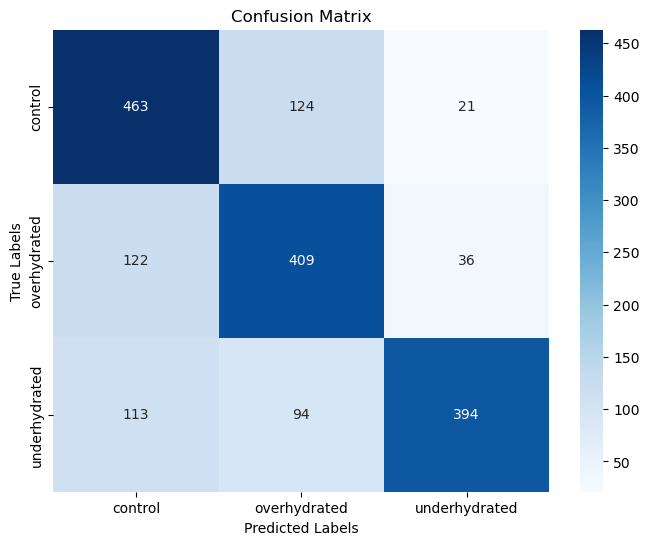

Classification Report:
               precision    recall  f1-score   support

      control       0.66      0.76      0.71       608
 overhydrated       0.65      0.72      0.69       567
underhydrated       0.87      0.66      0.75       601

     accuracy                           0.71      1776
    macro avg       0.73      0.71      0.71      1776
 weighted avg       0.73      0.71      0.71      1776



In [311]:
# lists for predictions and true labels
all_predictions = []
all_true_labels = []

# make predictions for every image in each test batch
for batch_images, batch_labels in test_tf_dataset:
    # apply vit_model to predict test images
    predictions = vit_model.predict(batch_images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(batch_labels, axis=1)

    all_predictions.extend(predicted_classes)
    all_true_labels.extend(true_classes)

    if len(all_true_labels) >= test_mod_batches.n:
        break

# make the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)
class_names = list(test_mod_batches.class_indices.keys())

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# classification report
report = classification_report(all_true_labels, all_predictions, target_names=class_names)
print("Classification Report:")
print(report)
